# Predicting the alpha signal using microblogging data

An alpha is an expression, applied to the cross-section of your universe of stocks, which returns a vector of real numbers where these values are predictive of the relative magnitude of future returns. An alpha could be built from a straight rank or it could be a vector of dimensionless numbers. Alphas are often referred to as factors

# Objective

The goal is to build a sentiment analysis model using the tagged data. This
sentiment analysis model should then be used to generate a new stock factor
which together with the other stock factors should be used to predict the Alpha
Signal

# Preprocessing of Train Data

## Importing Library and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
import spacy
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata
nlp = spacy.load("en_core_web_sm")
import emoji
import copy
warnings.filterwarnings("ignore")

In [2]:
data_factors = pd.read_csv("train_factors-1573207730757.csv")

In [3]:
data_factors.head(5)

,Id,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha
0,1,21/08/18,$NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2
1,2,11/10/18,$WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3
2,3,21/08/18,$DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1
3,4,10/07/18,$ge,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2
4,5,12/09/18,$FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2


In [4]:
jason_data = pd.read_json("train_data-1573118738755.json")

In [5]:
jason_data.head(5)

,records
0,{'stocktwit_tweet': '$AMD going up but hesitat...
1,{'stocktwit_tweet': '@inforlong @MariaGascon D...
2,"{'stocktwit_tweet': '$AVGO WTF?', 'sentiment_s..."
3,{'stocktwit_tweet': '$PH New Insider Filing O...
4,{'stocktwit_tweet': '$FB if it bounces tommorr...


In [6]:
data_twitter = pd.DataFrame([i for i in jason_data.records])

In [7]:
data_twitter.head(5)

,sentiment_score,stocktwit_tweet,ticker,timestamp
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19 18:38:28+00:00
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09 03:51:06+00:00
2,2,$AVGO WTF?,$AVGO,2018-07-12 13:35:32+00:00
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19 03:32:50+00:00
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23 19:07:54+00:00


In [8]:
data_twitter.shape

(1039131, 4)

### Converting Timestamp to Date format

In [9]:
data_twitter['Date']=data_twitter['timestamp'].str.split(expand=True)[0]

In [10]:
data_twitter['date']=pd.to_datetime(data_twitter['Date'].astype(str))

In [11]:
data_twitter.drop('timestamp',inplace=True,axis=1)

In [12]:
data_twitter.head(5)

,sentiment_score,stocktwit_tweet,ticker,Date,date
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,2018-10-09
2,2,$AVGO WTF?,$AVGO,2018-07-12,2018-07-12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,2018-07-19
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,2018-08-23


In [13]:
data_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039131 entries, 0 to 1039130
Data columns (total 5 columns):
sentiment_score    1039131 non-null int64
stocktwit_tweet    1039131 non-null object
ticker             1039131 non-null object
Date               1039131 non-null object
date               1039131 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 39.6+ MB


### Deleting Duplicate Records

In [14]:
data_twitter.duplicated(keep=False).sum()

43312

In [15]:
data_twitter.drop_duplicates(keep='first',inplace=True)

In [16]:
data_twitter.shape

(1009958, 5)

In [17]:
#data_twitter.drop('duplicate',inplace=True,axis=1)

In [18]:
data_twitter =data_twitter.reset_index(drop=True)

In [19]:
data_twitter.head(5)

,sentiment_score,stocktwit_tweet,ticker,Date,date
0,3,$AMD going up but hesitating however chart is ...,$AMD,2018-09-19,2018-09-19
1,3,@inforlong @MariaGascon Despite\nChina trade w...,$CAT,2018-10-09,2018-10-09
2,2,$AVGO WTF?,$AVGO,2018-07-12,2018-07-12
3,2,$PH\n New Insider Filing On: \n MULLER KLAUS P...,$PH,2018-07-19,2018-07-19
4,3,$FB if it bounces tommorrow do the right thing...,$FB,2018-08-23,2018-08-23


### Keeping original copy of data before cleaning

In [20]:

print(type(data_twitter['ticker']))
original_data = copy.deepcopy(data_twitter)
print(data_twitter.keys())
print(original_data.keys())

<class 'pandas.core.series.Series'>
Index(['sentiment_score', 'stocktwit_tweet', 'ticker', 'Date', 'date'], dtype='object')
Index(['sentiment_score', 'stocktwit_tweet', 'ticker', 'Date', 'date'], dtype='object')


### Functions to Expand Contractions

In [21]:
contractions = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}


def expand_contractions(text):
    for word in text.split():
        if word.lower() in contractions:
            text = text.replace(word, contractions[word.lower()])
    return text



### Functions to Remove Accented characters

In [22]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #https://docs.python.org/2/library/unicodedata.html
    return text



# Functions to remove scrub words

In [23]:
def scrub_words(text):
    #Replace \xao characters in text
    text = re.sub('\xa0', ' ', text)
    
    #Replace non ascii / not words and digits
    text = re.sub("(\\W|\\d)",' ',text)
    
    #Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)
    
    #Remove html markup
    text = re.sub("<.*?>", ' ', text)
    
    #Remove extra spaces from the text
    text = re.sub("\s+", ' ', text)
    return text

### Functions to clean Twitter related Data

In [24]:
#!pip install emoji

In [25]:
def cleaning_twitter_data(text):
    
    text= re.sub('http\S*|www.\S*','', text) #remove http/https address
    text= emoji.demojize(text)  #Convert emoji into text
    text= re.sub("_", ' ', text) #remove "_" from text
    text= text.strip().lower()  #Convert into lower case
    text= re.sub("@[\w]*","", text) #remove @twitter 
    text= re.sub("\$[\w]*","", text) #remove $sign
    
    text= re.sub("[#+]?\B","", text) #remove hashtags
    #text= re.sub("#","", text)
    text= expand_contractions(re.sub('’', "'", text)) #Expand contractions
    text= remove_accented_chars(text) #remove accented characters
    text= scrub_words(text) #remove scrub words
    return text

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [26]:
data_twitter['stocktwit_tweet']=data_twitter['stocktwit_tweet'].apply(strip_html_tags)

data_twitter['stocktwit_tweet']=data_twitter['stocktwit_tweet'].apply(lambda x: cleaning_twitter_data(x))

In [27]:
## Using TextBlob to spell correct.

#import textblob
#from textblob import TextBlob

#data_twitter['stocktwit_tweet'] = [TextBlob(text).correct() for text in data_twitter['stocktwit_tweet']]

In [28]:
print("Original data: \n",original_data['stocktwit_tweet'][14])
print("\n\n**************************************************************************\n\n")
print("Clean data: \n",data_twitter['stocktwit_tweet'][14])

Original data: 
 $ANTM


**************************************************************************


Clean data: 
 


### Remove dollar sign from ticker column

In [29]:
data_twitter['ticker']=data_twitter['ticker'].str.replace("$","")
data_twitter['ticker']=data_twitter['ticker'].str.upper()

In [30]:
data_twitter.to_csv("first.csv")

In [31]:
#data_twitter=pd.read_csv("first.csv")

### Function to Remove Stop words and stemming the words

In [32]:
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 

stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(stopwords))
print('First ten stop words: %s' % list(stopwords)[:10])
stopwords.remove('no')
stopwords.remove('not')
stopwords.add('utm');

stopwords.add('source');
stopwords.add('stocktwits');

stemmer = PorterStemmer()
tokenizer = ToktokTokenizer()
lemmatizer = WordNetLemmatizer()
def stopword_remove_lemma(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopwords]
    #filtered_tokens = [stemmer.stem(i) for i in filtered_tokens]
    filtered_tokens = [lemmatizer.lemmatize(i) for i in filtered_tokens]
    filtered_text = ' '.join(filtered_tokens) 

    return filtered_text

Number of stop words: 326
First ten stop words: ['her', 'namely', 'show', 'beyond', 'ours', 'enough', 'four', 'from', 'had', 'any']


In [33]:
data_twitter['stocktwit_tweet']=data_twitter['stocktwit_tweet'].apply(lambda x: stopword_remove_lemma(x))


In [34]:
print("Original data: \n",original_data['stocktwit_tweet'][14])
print("\n\n**************************************************************************\n\n")
print("Clean data: \n",data_twitter['stocktwit_tweet'][14])

Original data: 
 $ANTM


**************************************************************************


Clean data: 
 


In [35]:
data_twitter.to_csv('after_clean_data.csv')

### Check for Null values

In [36]:
data_twitter.isnull().sum()

sentiment_score    0
stocktwit_tweet    0
ticker             0
Date               0
date               0
dtype: int64

In [37]:
data_twitter[data_twitter['stocktwit_tweet']==""].count()

sentiment_score    27430
stocktwit_tweet    27430
ticker             27430
Date               27430
date               27430
dtype: int64

In [38]:
#data_twitter=data_twitter[data_twitter['stocktwit_tweet']!=""]

In [39]:
data_twitter['stocktwit_tweet'].isnull().sum()

0

In [40]:
data_twitter.shape

(1009958, 5)

# Preprocessing of Factors data

In [41]:
data_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27006 entries, 0 to 27005
Data columns (total 11 columns):
Id        27006 non-null int64
date      27006 non-null object
ticker    27006 non-null object
SF1       27006 non-null float64
SF2       27006 non-null float64
SF3       27006 non-null float64
SF4       27006 non-null float64
SF5       27006 non-null float64
SF6       27006 non-null float64
SF7       27006 non-null float64
alpha     27006 non-null int64
dtypes: float64(7), int64(2), object(2)
memory usage: 2.3+ MB


In [42]:
data_factors['date']=pd.to_datetime(data_factors['date'].astype(str),format="%d/%m/%y")

In [43]:
data_factors.isnull().sum()

Id        0
date      0
ticker    0
SF1       0
SF2       0
SF3       0
SF4       0
SF5       0
SF6       0
SF7       0
alpha     0
dtype: int64

In [44]:
data_factors.duplicated(keep=False).sum()

0

In [45]:
data_factors.drop('Id',axis=1,inplace=True)

### Remove dollar sign from ticker

In [46]:
data_factors['ticker'] = data_factors['ticker'].str.replace("$","")
data_factors['ticker']=data_factors['ticker'].str.upper()

### Adding month column

In [47]:
data_factors['month']=data_factors['date'].dt.month


In [48]:
data_twitter['month']=data_twitter['date'].dt.month


In [49]:
data_twitter.to_csv("final_data_twitter_main.csv")

In [50]:
data_factors.to_csv("final_data_factors_main.csv")

In [51]:
#data_twitter=pd.read_csv("final_data_twitter_main.csv",index_col=0)

In [52]:
#data_factors=pd.read_csv("final_data_factors_main.csv",index_col=0)

# Visualization


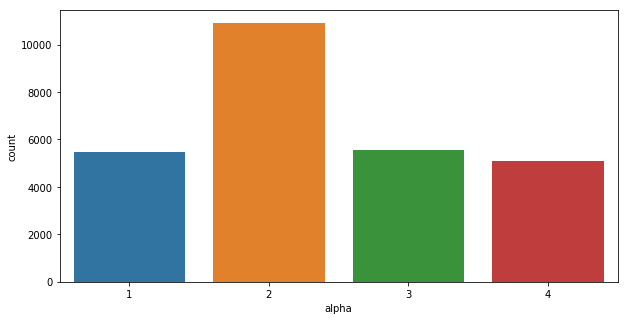

In [53]:
f, ax = plt.subplots(figsize=(10,5))
sns.countplot('alpha',data=data_factors);

#### @ Insights

Most of the Stock Alpha Values are 2

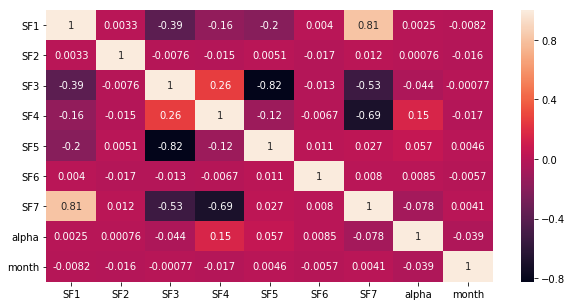

In [54]:
f, ax = plt.subplots(figsize=(10,5))
corr = data_factors.corr()
sns.heatmap(corr,annot=True);
plt.show()

#### @ Insights

SF1 and SF7 positively correlated

SF7 and SF3 negatively correlated

SF3 and SF5 negatively correlated

# Visualization for twitter dataset

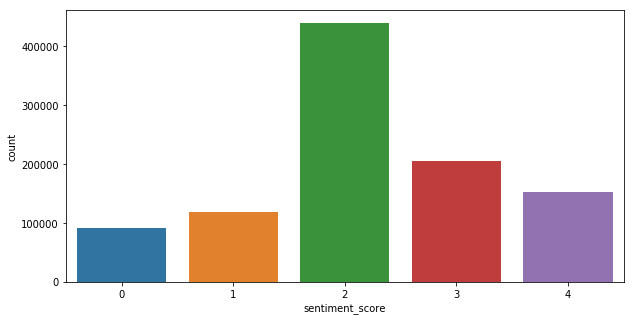

In [55]:
plt.subplots(figsize=(10,5))
sns.countplot('sentiment_score',data=data_twitter);

Most of the Sentiment Scores have values 2 in the Tweet, which indicate more of Neutral Sentiment

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

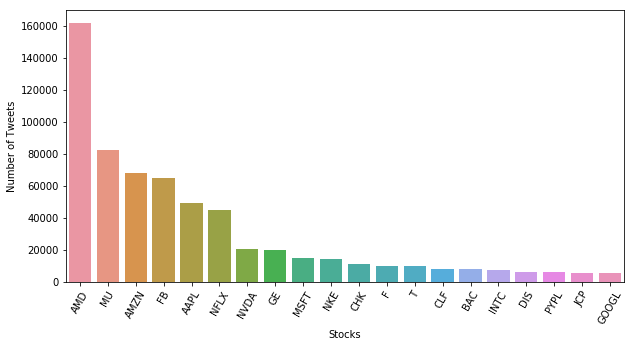

In [56]:
data = data_twitter.groupby('ticker')[['stocktwit_tweet']].count()
data=data.reset_index()
data=data.sort_values('stocktwit_tweet',ascending=False)
data.columns=["Stocks","Number of Tweets"]
plt.figure(figsize = (10,5))
sns.barplot(x='Stocks',y="Number of Tweets", data=data.head(20))
plt.xticks(rotation=60)

#### @ Insights

Advanced Micro Devices, Micron Technologies, Amazon and Facebook have the highest Number of Tweets

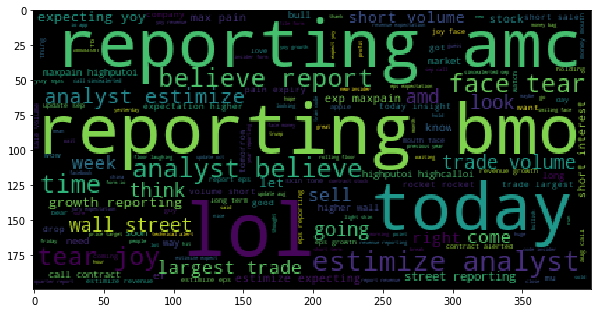

In [57]:
all_words = ' '.join([text for text in data_twitter['stocktwit_tweet']])
from wordcloud import WordCloud
wordcloud = WordCloud().generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.show()

#### @ Insights

General WordClouds have more of reporting and analysis of Stocks Terms in the Overall Corpus

In [58]:
from wordcloud import WordCloud


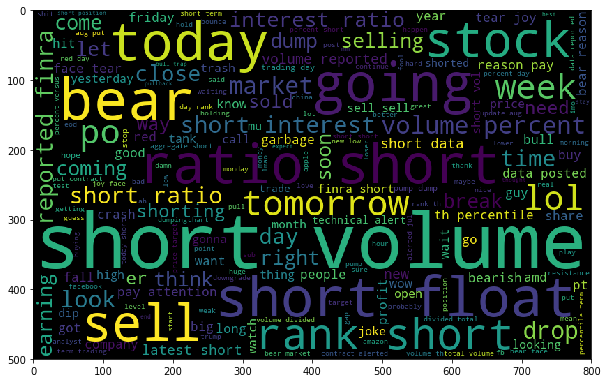

In [59]:
normal_words_0 =' '.join([text for text in data_twitter['stocktwit_tweet'][data_twitter['sentiment_score'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_0)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.show()

#### @ Insights

WordClouds with Sentiment Score 0 have words like bear,float,short and sell which correspond to negative Sentiments

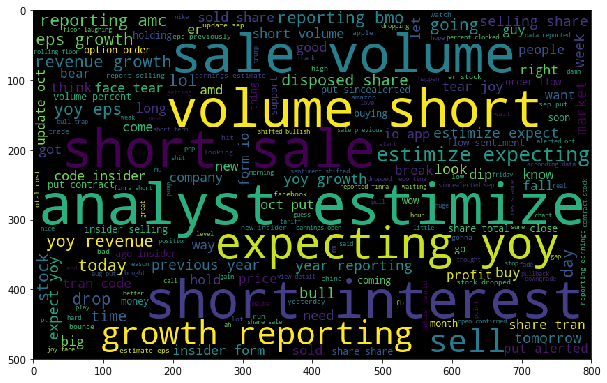

In [60]:
normal_words_1 =' '.join([text for text in data_twitter['stocktwit_tweet'][data_twitter['sentiment_score'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_1)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.show()

#### @ Insights

WordClouds with Sentiment Score 1 have words like volume,short,interest,growth,source and sell which correspond to kindoff Assertive Sentiments

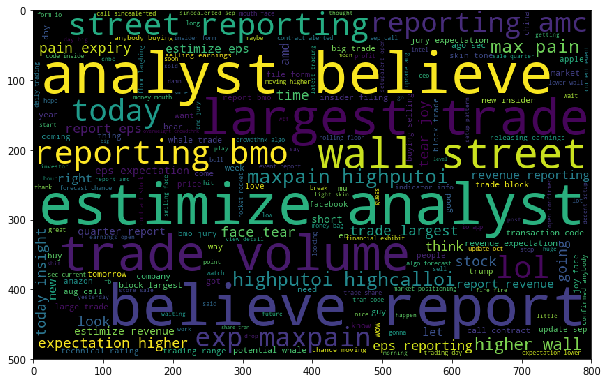

In [61]:
normal_words_2 =' '.join([text for text in data_twitter['stocktwit_tweet'][data_twitter['sentiment_score'] == 2]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_2)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.show()

#### @ Insights

WordClouds with Sentiment Score 2 have words like analyst,estimize,believe and report which correspond to comparitvely less Negative Sentiments

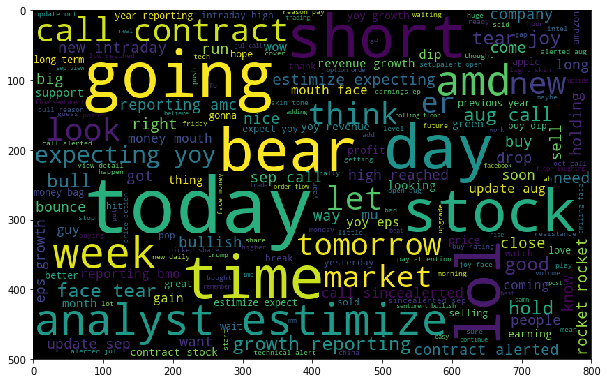

In [62]:
normal_words_3 =' '.join([text for text in data_twitter['stocktwit_tweet'][data_twitter['sentiment_score'] == 3]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_3)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.show()

#### @ Insights

WordClouds with Sentiment Score 3 have words like today,going,growth and stock which correspond to comparitvely Positive Sentiments


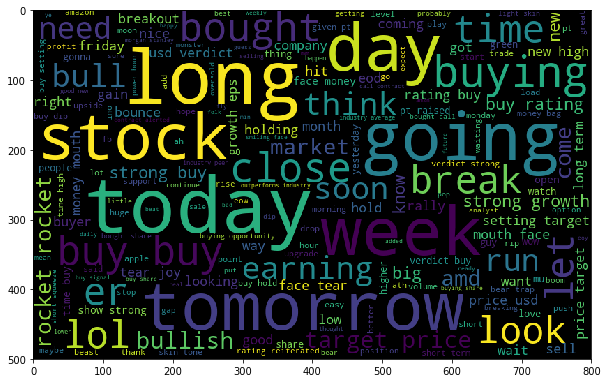

In [63]:
normal_words_4 =' '.join([text for text in data_twitter['stocktwit_tweet'][data_twitter['sentiment_score'] == 4]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words_4)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud)
plt.show()

#### @ Insights

WordClouds with Sentiment Score 4 have words like today,long,week,buying and bought correspond to Positive Sentiments

# Simple Model building for Twitter Data

In [64]:
data_twitter['sentiment_score']=data_twitter['sentiment_score'].astype('category')

In [65]:
X_data=data_twitter['stocktwit_tweet']
Y_data=data_twitter['sentiment_score']

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_data, Y_data, test_size = 0.3, random_state=42,stratify=Y_data)

In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
#tfidf = TfidfVectorizer(use_idf=True, ngram_range=(1,3))
train_v = tfidf.fit_transform(X_train_t)
test_v = tfidf.transform(X_test_t)

In [69]:
# Logistic regression
logreg = LogisticRegression()
logreg.fit(train_v,y_train_t)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [71]:
y_pred1=logreg.predict(train_v)
y_pred2=logreg.predict(test_v)


In [72]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def get_result(train,pred):
    count_misclassified = (train != pred).sum()
    print('Misclassified samples:',format(count_misclassified))
    accuracy = accuracy_score(train, pred)
    print('Accuracy:',format(accuracy))
    f1=f1_score(train, pred, average='macro')
    print('F1-Score:',format(f1))
    

In [73]:
# how did our model perform?

get_result(y_train_t,y_pred1)

Misclassified samples: 255967
Accuracy: 0.6379379605923873
F1-Score: 0.5678465053787096


In [74]:
# how did our model perform?
get_result(y_test_t,y_pred2)

Misclassified samples: 113958
Accuracy: 0.6238860944987921
F1-Score: 0.5497624274969014


# Simple Model building for Stocks factor Data

In [75]:
data_factors['alpha']=data_factors['alpha'].astype('category')

In [76]:
data_factors.head()

,date,ticker,SF1,SF2,SF3,SF4,SF5,SF6,SF7,alpha,month
0,2018-08-21,NTAP,-0.628652,0.988891,-0.055714,0.774379,0.551089,-1.329229,-0.995539,2,8
1,2018-10-11,WYNN,1.315786,1.438754,0.187327,0.608933,-1.153030,1.859441,0.730995,3,10
2,2018-08-21,DRI,-1.141388,-1.455016,0.332755,0.674502,0.111326,-0.478597,-1.488157,1,8
3,2018-07-10,GE,-0.054839,-1.454149,-0.162267,-0.681870,0.307869,-0.529987,0.404172,2,7
4,2018-09-12,FE,-0.686366,0.838865,0.073830,0.679024,0.329463,1.262782,-1.024042,2,9


In [77]:
X=data_factors.drop(['date','alpha','ticker','month'],axis=1)
y=data_factors['alpha']

In [78]:
cat_attr = list(X.select_dtypes("category").columns)
num_attr = list(X.columns.difference(cat_attr))

In [79]:
cat_attr

[]

In [80]:
#X = pd.get_dummies(X, sparse=True)
from sklearn import preprocessing 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
train_num_attr = Pipeline(steps=[('scaler', MinMaxScaler(feature_range=(0, 1)))])

train_cat_attr = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', train_num_attr, num_attr),
        ('cat', train_cat_attr, cat_attr)])

In [81]:
from sklearn.model_selection import train_test_split
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X, y, test_size = 0.3, random_state=42,stratify=y)

In [82]:
clf_linreg = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_s = clf_linreg.fit_transform(X_train_s)
X_test_s =clf_linreg.transform(X_test_s)

In [83]:
lg_s = LogisticRegression()
lg_s.fit(X_train_s,y_train_s)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
# Predicting the Train and Test set results
y_pred_lr_train= lg_s.predict(X_train_s)
y_pred_lr_test= lg_s.predict(X_test_s)

In [85]:
get_result(y_train_s,y_pred_lr_train)

Misclassified samples: 10586
Accuracy: 0.44001269572577234
F1-Score: 0.24497622713026332


In [86]:
get_result(y_test_s,y_pred_lr_test)

Misclassified samples: 4528
Accuracy: 0.44112564798815107
F1-Score: 0.24621460183696256


### Grouping the date, ticker and sentiment score 

In [87]:
data_twitter['date']=data_twitter['Date']

In [88]:
data_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009958 entries, 0 to 1009957
Data columns (total 6 columns):
sentiment_score    1009958 non-null category
stocktwit_tweet    1009958 non-null object
ticker             1009958 non-null object
Date               1009958 non-null object
date               1009958 non-null object
month              1009958 non-null int64
dtypes: category(1), int64(1), object(4)
memory usage: 39.5+ MB


In [89]:
data_twitter.drop('Date',axis=1,inplace=True)
#data_factors.drop(['month'],axis=1,inplace=True)

In [90]:
data_twitter['ticker']=data_twitter['ticker'].str.upper()

In [92]:
group_data = data_twitter.groupby(by=['date','ticker'])['sentiment_score'].apply(lambda x:x.value_counts().index[0]).to_frame()


In [93]:
group_data.shape

(57606, 1)

In [94]:
sample=data_twitter


In [95]:
sample=sample.drop_duplicates(subset=['date', 'ticker'],keep='first')

In [97]:
sample.duplicated(['date','ticker'],keep=False).sum()

0

In [98]:
data_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009958 entries, 0 to 1009957
Data columns (total 5 columns):
sentiment_score    1009958 non-null category
stocktwit_tweet    1009958 non-null object
ticker             1009958 non-null object
date               1009958 non-null object
month              1009958 non-null int64
dtypes: category(1), int64(1), object(3)
memory usage: 31.8+ MB
